In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout, Embedding,Flatten,Conv1D,MaxPooling1D,BatchNormalization,GlobalMaxPooling1D
from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.utils import to_categorical #One-hot encoder
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
import gc
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import f1_score

In [2]:
train = pd.read_csv("data/train.csv",
                usecols=['session_id','elapsed_time','level_group'])
print(train.shape)
train.head()

(13174211, 3)


,session_id,elapsed_time,level_group
0,20090312431273200,0,0-4
1,20090312431273200,1323,0-4
2,20090312431273200,831,0-4
3,20090312431273200,1147,0-4
4,20090312431273200,1863,0-4


In [3]:
target = pd.read_csv("data/train_labels.csv")
tmp = target.session_id.str.split("_", expand =True)
target["user_id"] = tmp[0].astype("int")
target["q"] = tmp[1].str.slice(1).astype("int")
print(target.shape)
target.head()

(212022, 4)


,session_id,correct,user_id,q
0,20090312431273200_q1,1,20090312431273200,1
1,20090312433251036_q1,0,20090312433251036,1
2,20090314121766812_q1,1,20090314121766812,1
3,20090314363702160_q1,1,20090314363702160,1
4,20090314441803444_q1,1,20090314441803444,1


In [4]:
train.session_id.nunique(), target.user_id.nunique()

(11779, 11779)

# FEATURE ENGINEERING:

In [5]:
GP1 = '0-4'
GP2 = '5-12'
GP3 = '13-22'

GROUP_DATA = {
    GP1: {
        "data": [],
        'target': target[(target.q >= 1) & (target.q <= 3)] # 只有train data會用到這個 /test不會
    },
    GP2: {
        "data": [],
        'target': target[(target.q >= 4) & (target.q <= 13)]
    },
    GP3: {
        "data":  [],
        'target': target[(target.q >= 14) & (target.q <= 18)]
    }
}


# cut_len = {}
grp=[GP1,GP2,GP3]
def feature_engineer(df):
    df = df.loc[:,['session_id','elapsed_time','level_group']]
#     event_duration
    df.elapsed_time /= 1000 #轉為秒
    event_duration = df.elapsed_time.diff().fillna(0).clip(0,3600).astype("float32") #最大道3600秒也就是一小時
    df['event_duration'] = event_duration.astype("float32")
    df.drop('elapsed_time', axis = 1, inplace =True)
    
    #每個level_group要pad_sequence的長度
#     for level in grp:
#         sequence_len = np.ceil(df[df["level_group"] == level].groupby(["session_id","level_group"]).agg("count").mean()).astype("int") #擷取每個level_group的事件長度為平均數
#         cut_len[level] = sequence_len
        
    for level in grp:
        GROUP_DATA[level]["data"] = df[df["level_group"] ==level]
        
    for level in grp:
        tmp = []
        user_id = []
        for session_id, info in GROUP_DATA[level]["data"].groupby("session_id"):
            tmp.append(info['event_duration'].astype("float32"))
            user_id.append(session_id)
        GROUP_DATA[level]["data"] = pad_sequences(tmp, padding='post', maxlen = 500,dtype='float16')
    return df

In [6]:
feature_engineer(train)

,session_id,level_group,event_duration
0,20090312431273200,0-4,0.000
1,20090312431273200,0-4,1.323
2,20090312431273200,0-4,0.000
3,20090312431273200,0-4,0.316
4,20090312431273200,0-4,0.716
...,...,...,...
13174206,22100221145014656,13-22,1.046
13174207,22100221145014656,13-22,1.935
13174208,22100221145014656,13-22,0.751
13174209,22100221145014656,13-22,0.836


In [7]:
_ = gc.collect()

In [8]:
for level in grp:
    print(GROUP_DATA[level]["data"].shape, GROUP_DATA[level]["target"].user_id.nunique())

(11779, 500) 11779
(11779, 500) 11779
(11779, 500) 11779


In [9]:
GROUP_DATA[GP1]["data"][0][:5]

array([0.   , 1.323, 0.   , 0.316, 0.716], dtype=float16)

In [10]:
GROUP_DATA[GP1]["target"].head(2)

,session_id,correct,user_id,q
0,20090312431273200_q1,1,20090312431273200,1
1,20090312433251036_q1,0,20090312433251036,1


In [11]:
_ = gc.collect()

# Conv1D model

In [12]:
def train_model(dim): 
    model = Sequential()
    model.add(Embedding(input_dim=dim, output_dim=128, input_length=500))
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(1, activation='sigmoid'))
    return model

In [13]:
train_model(100).summary()

Metal device set to: Apple M1 Max
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 128)          12800     
                                                                 
 conv1d (Conv1D)             (None, 498, 32)           12320     
                                                                 
 global_max_pooling1d (Globa  (None, 32)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 64)                2112      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                      

2023-05-04 10:51:16.051886: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-05-04 10:51:16.052392: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


# Train

In [14]:
ALL_USER = train.session_id.unique()
len(ALL_USER)

11779

In [15]:
pred_df = pd.DataFrame(np.zeros((len(ALL_USER),18)), index= ALL_USER,columns=range(1,19))
pred_df.head(3)

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
20090312431273200,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20090312433251036,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20090314121766812,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
# keep_model = {}
ques_grp = {GP1:(1,4),GP2:(4,14),GP3:(14,19)}
# save_history = []

# tb_callback = tf.keras.callbacks.TensorBoard('./logs', update_freq=1)
for level in grp:
    a, b = ques_grp[level]
    for Q in range(a,b):
        model = train_model(int(GROUP_DATA[level]["data"].max())+1 #最大的數字要再+1曾能送到embedding因為embedding會試左閉又開，不包含傳入的.max()值
                        )
        model.compile(loss="binary_crossentropy", optimizer = "adam",metrics = "accuracy")
        grp_target = GROUP_DATA[level]["target"]
        y_label = grp_target[grp_target.q == Q].correct
        
        
        model_checkpoint_callback = ModelCheckpoint(
                                    filepath=f'{level}_{Q}/checkpoint',
                                    save_weights_only= False,
                                    monitor='val_accuracy',
                                    mode='max',
                                    save_best_only=True)
        
        print(f"NUM: {Q}")
        History = model.fit(GROUP_DATA[level]["data"],
                            y_label,validation_split=0.1, 
                            epochs=20, 
                            batch_size= 32,
                            verbose = 1,
                            callbacks = [model_checkpoint_callback])
#         save_history.append(History)
        loss, acc = model.evaluate(GROUP_DATA[level]["data"],
                                   y_label)
        y_pred = model.predict(GROUP_DATA[level]["data"])
#         keep_model[f"{level}_{Q}"] = model
        pred_df[Q] = y_pred

NUM: 1
Epoch 1/20


2023-05-04 10:51:16.449048: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-05-04 10:51:16.725097: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


332/332 [==============================] - ETA: 0s - loss: 0.5934 - accuracy: 0.7229

2023-05-04 10:51:36.080940: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: 0-4_1/checkpoint/assets


INFO:tensorflow:Assets written to: 0-4_1/checkpoint/assets


332/332 [==============================] - 20s 60ms/step - loss: 0.5934 - accuracy: 0.7229 - val_loss: 0.5702 - val_accuracy: 0.7334
Epoch 2/20
332/332 [==============================] - 21s 64ms/step - loss: 0.5734 - accuracy: 0.7231 - val_loss: 0.5631 - val_accuracy: 0.7334
Epoch 3/20
332/332 [==============================] - 15s 46ms/step - loss: 0.5601 - accuracy: 0.7238 - val_loss: 0.5657 - val_accuracy: 0.7275
Epoch 4/20
332/332 [==============================] - 18s 55ms/step - loss: 0.5489 - accuracy: 0.7308 - val_loss: 0.5671 - val_accuracy: 0.7258
Epoch 5/20
332/332 [==============================] - 17s 51ms/step - loss: 0.5435 - accuracy: 0.7396 - val_loss: 0.5671 - val_accuracy: 0.7250
Epoch 6/20
332/332 [==============================] - 13s 38ms/step - loss: 0.5342 - accuracy: 0.7419 - val_loss: 0.5690 - val_accuracy: 0.7233
Epoch 7/20
332/332 [==============================] - 12s 36ms/step - loss: 0.5269 - accuracy: 0.7465 - val_loss: 0.5825 - val_accuracy: 0.7114
Epo

2023-05-04 10:54:51.570013: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


369/369 [==============================] - 1s 2ms/step
NUM: 2
Epoch 1/20


2023-05-04 10:54:52.731014: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


332/332 [==============================] - ETA: 0s - loss: 0.1294 - accuracy: 0.9785

2023-05-04 10:55:30.582098: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: 0-4_2/checkpoint/assets


INFO:tensorflow:Assets written to: 0-4_2/checkpoint/assets


332/332 [==============================] - 39s 116ms/step - loss: 0.1294 - accuracy: 0.9785 - val_loss: 0.1127 - val_accuracy: 0.9762
Epoch 2/20
332/332 [==============================] - 37s 112ms/step - loss: 0.1045 - accuracy: 0.9791 - val_loss: 0.1118 - val_accuracy: 0.9762
Epoch 3/20
332/332 [==============================] - 42s 127ms/step - loss: 0.1013 - accuracy: 0.9791 - val_loss: 0.1158 - val_accuracy: 0.9762
Epoch 4/20
332/332 [==============================] - 41s 125ms/step - loss: 0.0993 - accuracy: 0.9791 - val_loss: 0.1160 - val_accuracy: 0.9762
Epoch 5/20
332/332 [==============================] - 41s 124ms/step - loss: 0.0938 - accuracy: 0.9791 - val_loss: 0.1217 - val_accuracy: 0.9762
Epoch 6/20
332/332 [==============================] - 41s 124ms/step - loss: 0.0913 - accuracy: 0.9791 - val_loss: 0.1208 - val_accuracy: 0.9762
Epoch 7/20
332/332 [==============================] - 41s 124ms/step - loss: 0.0878 - accuracy: 0.9791 - val_loss: 0.1215 - val_accuracy: 0.9

2023-05-04 11:05:32.890151: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


369/369 [==============================] - 1s 2ms/step
NUM: 3
Epoch 1/20


2023-05-04 11:05:34.420414: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


332/332 [==============================] - ETA: 0s - loss: 0.2728 - accuracy: 0.9309

2023-05-04 11:05:57.264125: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: 0-4_3/checkpoint/assets


INFO:tensorflow:Assets written to: 0-4_3/checkpoint/assets


332/332 [==============================] - 24s 71ms/step - loss: 0.2728 - accuracy: 0.9309 - val_loss: 0.2246 - val_accuracy: 0.9414
Epoch 2/20
332/332 [==============================] - 30s 89ms/step - loss: 0.2534 - accuracy: 0.9311 - val_loss: 0.2225 - val_accuracy: 0.9414
Epoch 3/20
332/332 [==============================] - 13s 40ms/step - loss: 0.2480 - accuracy: 0.9311 - val_loss: 0.2231 - val_accuracy: 0.9414
Epoch 4/20
332/332 [==============================] - 14s 42ms/step - loss: 0.2433 - accuracy: 0.9311 - val_loss: 0.2213 - val_accuracy: 0.9414
Epoch 5/20
332/332 [==============================] - 12s 37ms/step - loss: 0.2381 - accuracy: 0.9311 - val_loss: 0.2335 - val_accuracy: 0.9414
Epoch 6/20
332/332 [==============================] - 14s 42ms/step - loss: 0.2317 - accuracy: 0.9311 - val_loss: 0.2228 - val_accuracy: 0.9414
Epoch 7/20
332/332 [==============================] - 14s 43ms/step - loss: 0.2268 - accuracy: 0.9311 - val_loss: 0.2236 - val_accuracy: 0.9414
Epo

2023-05-04 11:09:55.521160: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


369/369 [==============================] - 1s 2ms/step
NUM: 4
Epoch 1/20


2023-05-04 11:09:56.787346: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


332/332 [==============================] - ETA: 0s - loss: 0.5100 - accuracy: 0.7991

2023-05-04 11:10:07.526845: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: 5-12_4/checkpoint/assets


INFO:tensorflow:Assets written to: 5-12_4/checkpoint/assets


332/332 [==============================] - 12s 35ms/step - loss: 0.5100 - accuracy: 0.7991 - val_loss: 0.4969 - val_accuracy: 0.8014
Epoch 2/20
332/332 [==============================] - 12s 35ms/step - loss: 0.5003 - accuracy: 0.7991 - val_loss: 0.4938 - val_accuracy: 0.8014
Epoch 3/20
332/332 [==============================] - 11s 35ms/step - loss: 0.4945 - accuracy: 0.7993 - val_loss: 0.4935 - val_accuracy: 0.8014
Epoch 4/20
332/332 [==============================] - 11s 33ms/step - loss: 0.4878 - accuracy: 0.7994 - val_loss: 0.5040 - val_accuracy: 0.8014
Epoch 5/20
332/332 [==============================] - 12s 36ms/step - loss: 0.4772 - accuracy: 0.7990 - val_loss: 0.5016 - val_accuracy: 0.8014
Epoch 6/20
332/332 [==============================] - 12s 37ms/step - loss: 0.4736 - accuracy: 0.7995 - val_loss: 0.4990 - val_accuracy: 0.8014
Epoch 7/20
332/332 [==============================] - 12s 35ms/step - loss: 0.4628 - accuracy: 0.8020 - val_loss: 0.5000 - val_accuracy: 0.8014
Epo

INFO:tensorflow:Assets written to: 5-12_4/checkpoint/assets


INFO:tensorflow:Assets written to: 5-12_4/checkpoint/assets


332/332 [==============================] - 17s 51ms/step - loss: 0.4242 - accuracy: 0.8161 - val_loss: 0.5285 - val_accuracy: 0.8022
Epoch 13/20
332/332 [==============================] - 13s 40ms/step - loss: 0.4172 - accuracy: 0.8178 - val_loss: 0.5482 - val_accuracy: 0.7649
Epoch 14/20
332/332 [==============================] - 15s 46ms/step - loss: 0.4110 - accuracy: 0.8227 - val_loss: 0.5544 - val_accuracy: 0.7886
Epoch 15/20
332/332 [==============================] - 13s 38ms/step - loss: 0.4055 - accuracy: 0.8228 - val_loss: 0.5650 - val_accuracy: 0.7683
Epoch 16/20
332/332 [==============================] - 13s 40ms/step - loss: 0.3972 - accuracy: 0.8252 - val_loss: 0.5705 - val_accuracy: 0.7793
Epoch 17/20
332/332 [==============================] - 12s 38ms/step - loss: 0.3927 - accuracy: 0.8274 - val_loss: 0.5785 - val_accuracy: 0.7666
Epoch 18/20
332/332 [==============================] - 12s 36ms/step - loss: 0.3856 - accuracy: 0.8301 - val_loss: 0.5988 - val_accuracy: 0.79

2023-05-04 11:14:21.867195: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


369/369 [==============================] - 1s 2ms/step
NUM: 5
Epoch 1/20


2023-05-04 11:14:23.009005: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


332/332 [==============================] - ETA: 0s - loss: 0.6882 - accuracy: 0.5449

2023-05-04 11:14:35.326524: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: 5-12_5/checkpoint/assets


INFO:tensorflow:Assets written to: 5-12_5/checkpoint/assets


332/332 [==============================] - 14s 40ms/step - loss: 0.6882 - accuracy: 0.5449 - val_loss: 0.6816 - val_accuracy: 0.5764
Epoch 2/20
332/332 [==============================] - 14s 43ms/step - loss: 0.6844 - accuracy: 0.5603 - val_loss: 0.6767 - val_accuracy: 0.5739
Epoch 3/20
331/332 [============================>.] - ETA: 0s - loss: 0.6769 - accuracy: 0.5740

INFO:tensorflow:Assets written to: 5-12_5/checkpoint/assets


INFO:tensorflow:Assets written to: 5-12_5/checkpoint/assets


332/332 [==============================] - 16s 48ms/step - loss: 0.6769 - accuracy: 0.5740 - val_loss: 0.6738 - val_accuracy: 0.5959
Epoch 4/20
332/332 [==============================] - 11s 33ms/step - loss: 0.6706 - accuracy: 0.5871 - val_loss: 0.6749 - val_accuracy: 0.5722
Epoch 5/20
332/332 [==============================] - 10s 31ms/step - loss: 0.6638 - accuracy: 0.6071 - val_loss: 0.6764 - val_accuracy: 0.5832
Epoch 6/20
332/332 [==============================] - 9s 27ms/step - loss: 0.6533 - accuracy: 0.6123 - val_loss: 0.6786 - val_accuracy: 0.5798
Epoch 7/20
332/332 [==============================] - 7s 22ms/step - loss: 0.6423 - accuracy: 0.6253 - val_loss: 0.6915 - val_accuracy: 0.5756
Epoch 8/20
332/332 [==============================] - 7s 21ms/step - loss: 0.6318 - accuracy: 0.6329 - val_loss: 0.6984 - val_accuracy: 0.5526
Epoch 9/20
332/332 [==============================] - 7s 21ms/step - loss: 0.6203 - accuracy: 0.6409 - val_loss: 0.6974 - val_accuracy: 0.5611
Epoch 1

2023-05-04 11:17:12.010514: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


369/369 [==============================] - 1s 2ms/step
NUM: 6
Epoch 1/20


2023-05-04 11:17:13.233153: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


332/332 [==============================] - ETA: 0s - loss: 0.5440 - accuracy: 0.7712

2023-05-04 11:17:35.450878: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: 5-12_6/checkpoint/assets


INFO:tensorflow:Assets written to: 5-12_6/checkpoint/assets


332/332 [==============================] - 24s 70ms/step - loss: 0.5440 - accuracy: 0.7712 - val_loss: 0.5247 - val_accuracy: 0.7776
Epoch 2/20
332/332 [==============================] - 15s 46ms/step - loss: 0.5325 - accuracy: 0.7714 - val_loss: 0.5237 - val_accuracy: 0.7776
Epoch 3/20
332/332 [==============================] - 17s 50ms/step - loss: 0.5264 - accuracy: 0.7714 - val_loss: 0.5288 - val_accuracy: 0.7776
Epoch 4/20
332/332 [==============================] - 15s 45ms/step - loss: 0.5187 - accuracy: 0.7715 - val_loss: 0.5245 - val_accuracy: 0.7776
Epoch 5/20
332/332 [==============================] - 16s 48ms/step - loss: 0.5100 - accuracy: 0.7723 - val_loss: 0.5301 - val_accuracy: 0.7742
Epoch 6/20
332/332 [==============================] - 15s 47ms/step - loss: 0.5046 - accuracy: 0.7761 - val_loss: 0.5349 - val_accuracy: 0.7683
Epoch 7/20
332/332 [==============================] - 14s 41ms/step - loss: 0.4938 - accuracy: 0.7791 - val_loss: 0.5393 - val_accuracy: 0.7699
Epo

2023-05-04 11:21:57.659548: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


369/369 [==============================] - 1s 2ms/step
NUM: 7
Epoch 1/20


2023-05-04 11:21:58.914178: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


332/332 [==============================] - ETA: 0s - loss: 0.5906 - accuracy: 0.7261

2023-05-04 11:22:19.092521: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: 5-12_7/checkpoint/assets


INFO:tensorflow:Assets written to: 5-12_7/checkpoint/assets


332/332 [==============================] - 22s 63ms/step - loss: 0.5906 - accuracy: 0.7261 - val_loss: 0.5697 - val_accuracy: 0.7538
Epoch 2/20
332/332 [==============================] - 16s 49ms/step - loss: 0.5847 - accuracy: 0.7265 - val_loss: 0.5594 - val_accuracy: 0.7538
Epoch 3/20
332/332 [==============================] - 24s 73ms/step - loss: 0.5792 - accuracy: 0.7265 - val_loss: 0.5551 - val_accuracy: 0.7538
Epoch 4/20
332/332 [==============================] - 19s 56ms/step - loss: 0.5720 - accuracy: 0.7266 - val_loss: 0.5538 - val_accuracy: 0.7538
Epoch 5/20
332/332 [==============================] - 16s 49ms/step - loss: 0.5632 - accuracy: 0.7296 - val_loss: 0.5562 - val_accuracy: 0.7530
Epoch 6/20
332/332 [==============================] - 14s 43ms/step - loss: 0.5542 - accuracy: 0.7324 - val_loss: 0.5621 - val_accuracy: 0.7496
Epoch 7/20
332/332 [==============================] - 14s 42ms/step - loss: 0.5446 - accuracy: 0.7391 - val_loss: 0.5619 - val_accuracy: 0.7462
Epo

2023-05-04 11:25:56.726753: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


369/369 [==============================] - 1s 2ms/step
NUM: 8
Epoch 1/20


2023-05-04 11:25:58.024240: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


332/332 [==============================] - ETA: 0s - loss: 0.6701 - accuracy: 0.6123

2023-05-04 11:26:10.228456: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: 5-12_8/checkpoint/assets


INFO:tensorflow:Assets written to: 5-12_8/checkpoint/assets


332/332 [==============================] - 14s 40ms/step - loss: 0.6701 - accuracy: 0.6123 - val_loss: 0.6614 - val_accuracy: 0.6307
Epoch 2/20
332/332 [==============================] - 14s 43ms/step - loss: 0.6678 - accuracy: 0.6125 - val_loss: 0.6618 - val_accuracy: 0.6307
Epoch 3/20
332/332 [==============================] - 13s 38ms/step - loss: 0.6650 - accuracy: 0.6125 - val_loss: 0.6577 - val_accuracy: 0.6307
Epoch 4/20
332/332 [==============================] - 13s 38ms/step - loss: 0.6619 - accuracy: 0.6125 - val_loss: 0.6611 - val_accuracy: 0.6307
Epoch 5/20
332/332 [==============================] - 10s 30ms/step - loss: 0.6561 - accuracy: 0.6151 - val_loss: 0.6700 - val_accuracy: 0.6087
Epoch 6/20
332/332 [==============================] - 11s 32ms/step - loss: 0.6496 - accuracy: 0.6229 - val_loss: 0.6641 - val_accuracy: 0.6214
Epoch 7/20
332/332 [==============================] - 11s 33ms/step - loss: 0.6404 - accuracy: 0.6326 - val_loss: 0.6783 - val_accuracy: 0.5722
Epo

2023-05-04 11:28:48.858246: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


369/369 [==============================] - 1s 2ms/step
NUM: 9
Epoch 1/20


2023-05-04 11:28:50.152183: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


332/332 [==============================] - ETA: 0s - loss: 0.5874 - accuracy: 0.7320

2023-05-04 11:29:02.175722: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: 5-12_9/checkpoint/assets


INFO:tensorflow:Assets written to: 5-12_9/checkpoint/assets


332/332 [==============================] - 14s 39ms/step - loss: 0.5874 - accuracy: 0.7320 - val_loss: 0.5490 - val_accuracy: 0.7657
Epoch 2/20
332/332 [==============================] - 16s 47ms/step - loss: 0.5795 - accuracy: 0.7321 - val_loss: 0.5416 - val_accuracy: 0.7657
Epoch 3/20
332/332 [==============================] - 18s 55ms/step - loss: 0.5734 - accuracy: 0.7321 - val_loss: 0.5463 - val_accuracy: 0.7657
Epoch 4/20
332/332 [==============================] - 20s 61ms/step - loss: 0.5664 - accuracy: 0.7322 - val_loss: 0.5392 - val_accuracy: 0.7657
Epoch 5/20
332/332 [==============================] - 18s 54ms/step - loss: 0.5602 - accuracy: 0.7324 - val_loss: 0.5431 - val_accuracy: 0.7657
Epoch 6/20
332/332 [==============================] - 20s 60ms/step - loss: 0.5511 - accuracy: 0.7343 - val_loss: 0.5500 - val_accuracy: 0.7581
Epoch 7/20
332/332 [==============================] - 24s 73ms/step - loss: 0.5433 - accuracy: 0.7412 - val_loss: 0.5522 - val_accuracy: 0.7606
Epo

2023-05-04 11:35:11.551702: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


369/369 [==============================] - 1s 2ms/step
NUM: 10
Epoch 1/20


2023-05-04 11:35:12.820609: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


332/332 [==============================] - ETA: 0s - loss: 0.6908 - accuracy: 0.5284

2023-05-04 11:35:25.927227: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: 5-12_10/checkpoint/assets


INFO:tensorflow:Assets written to: 5-12_10/checkpoint/assets


332/332 [==============================] - 15s 42ms/step - loss: 0.6908 - accuracy: 0.5284 - val_loss: 0.6891 - val_accuracy: 0.5289
Epoch 2/20
332/332 [==============================] - ETA: 0s - loss: 0.6876 - accuracy: 0.5450

INFO:tensorflow:Assets written to: 5-12_10/checkpoint/assets


INFO:tensorflow:Assets written to: 5-12_10/checkpoint/assets


332/332 [==============================] - 14s 41ms/step - loss: 0.6876 - accuracy: 0.5450 - val_loss: 0.6861 - val_accuracy: 0.5416
Epoch 3/20
332/332 [==============================] - ETA: 0s - loss: 0.6825 - accuracy: 0.5608

INFO:tensorflow:Assets written to: 5-12_10/checkpoint/assets


INFO:tensorflow:Assets written to: 5-12_10/checkpoint/assets


332/332 [==============================] - 17s 53ms/step - loss: 0.6825 - accuracy: 0.5608 - val_loss: 0.6875 - val_accuracy: 0.5501
Epoch 4/20
332/332 [==============================] - ETA: 0s - loss: 0.6782 - accuracy: 0.5742

INFO:tensorflow:Assets written to: 5-12_10/checkpoint/assets


INFO:tensorflow:Assets written to: 5-12_10/checkpoint/assets


332/332 [==============================] - 17s 52ms/step - loss: 0.6782 - accuracy: 0.5742 - val_loss: 0.6860 - val_accuracy: 0.5552
Epoch 5/20
332/332 [==============================] - 12s 38ms/step - loss: 0.6718 - accuracy: 0.5865 - val_loss: 0.6887 - val_accuracy: 0.5416
Epoch 6/20
331/332 [============================>.] - ETA: 0s - loss: 0.6659 - accuracy: 0.5896

INFO:tensorflow:Assets written to: 5-12_10/checkpoint/assets


INFO:tensorflow:Assets written to: 5-12_10/checkpoint/assets


332/332 [==============================] - 12s 35ms/step - loss: 0.6660 - accuracy: 0.5894 - val_loss: 0.6891 - val_accuracy: 0.5620
Epoch 7/20
332/332 [==============================] - 9s 27ms/step - loss: 0.6567 - accuracy: 0.6034 - val_loss: 0.7006 - val_accuracy: 0.5475
Epoch 8/20
332/332 [==============================] - 10s 29ms/step - loss: 0.6471 - accuracy: 0.6086 - val_loss: 0.7009 - val_accuracy: 0.5238
Epoch 9/20
332/332 [==============================] - 7s 22ms/step - loss: 0.6339 - accuracy: 0.6223 - val_loss: 0.7086 - val_accuracy: 0.5416
Epoch 10/20
332/332 [==============================] - 8s 23ms/step - loss: 0.6229 - accuracy: 0.6268 - val_loss: 0.7210 - val_accuracy: 0.5441
Epoch 11/20
332/332 [==============================] - 8s 23ms/step - loss: 0.6110 - accuracy: 0.6409 - val_loss: 0.7386 - val_accuracy: 0.5348
Epoch 12/20
332/332 [==============================] - 7s 22ms/step - loss: 0.5991 - accuracy: 0.6448 - val_loss: 0.7494 - val_accuracy: 0.5331
Epoch

2023-05-04 11:38:26.457595: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


369/369 [==============================] - 1s 2ms/step
NUM: 11
Epoch 1/20


2023-05-04 11:38:27.888698: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


332/332 [==============================] - ETA: 0s - loss: 0.6536 - accuracy: 0.6440

2023-05-04 11:38:43.054492: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: 5-12_11/checkpoint/assets


INFO:tensorflow:Assets written to: 5-12_11/checkpoint/assets


332/332 [==============================] - 17s 48ms/step - loss: 0.6536 - accuracy: 0.6440 - val_loss: 0.6527 - val_accuracy: 0.6452
Epoch 2/20
332/332 [==============================] - 18s 54ms/step - loss: 0.6472 - accuracy: 0.6439 - val_loss: 0.6465 - val_accuracy: 0.6452
Epoch 3/20
332/332 [==============================] - 19s 59ms/step - loss: 0.6409 - accuracy: 0.6440 - val_loss: 0.6518 - val_accuracy: 0.6452
Epoch 4/20
332/332 [==============================] - ETA: 0s - loss: 0.6358 - accuracy: 0.6490

INFO:tensorflow:Assets written to: 5-12_11/checkpoint/assets


INFO:tensorflow:Assets written to: 5-12_11/checkpoint/assets


332/332 [==============================] - 17s 51ms/step - loss: 0.6358 - accuracy: 0.6490 - val_loss: 0.6440 - val_accuracy: 0.6469
Epoch 5/20
332/332 [==============================] - 22s 65ms/step - loss: 0.6284 - accuracy: 0.6560 - val_loss: 0.6450 - val_accuracy: 0.6316
Epoch 6/20
332/332 [==============================] - 16s 49ms/step - loss: 0.6165 - accuracy: 0.6649 - val_loss: 0.6452 - val_accuracy: 0.6401
Epoch 7/20
332/332 [==============================] - 15s 44ms/step - loss: 0.6081 - accuracy: 0.6693 - val_loss: 0.6487 - val_accuracy: 0.6231
Epoch 8/20
332/332 [==============================] - 12s 37ms/step - loss: 0.5985 - accuracy: 0.6797 - val_loss: 0.6432 - val_accuracy: 0.6307
Epoch 9/20
332/332 [==============================] - 12s 37ms/step - loss: 0.5889 - accuracy: 0.6867 - val_loss: 0.6491 - val_accuracy: 0.6375
Epoch 10/20
332/332 [==============================] - 11s 34ms/step - loss: 0.5783 - accuracy: 0.6897 - val_loss: 0.6581 - val_accuracy: 0.6324
Ep

2023-05-04 11:43:01.219593: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


369/369 [==============================] - 1s 2ms/step
NUM: 12
Epoch 1/20


2023-05-04 11:43:02.918238: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


332/332 [==============================] - ETA: 0s - loss: 0.4239 - accuracy: 0.8553

2023-05-04 11:43:18.961607: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: 5-12_12/checkpoint/assets


INFO:tensorflow:Assets written to: 5-12_12/checkpoint/assets


332/332 [==============================] - 18s 50ms/step - loss: 0.4239 - accuracy: 0.8553 - val_loss: 0.3873 - val_accuracy: 0.8710
Epoch 2/20
332/332 [==============================] - 15s 47ms/step - loss: 0.4143 - accuracy: 0.8560 - val_loss: 0.3849 - val_accuracy: 0.8710
Epoch 3/20
332/332 [==============================] - 15s 46ms/step - loss: 0.4109 - accuracy: 0.8560 - val_loss: 0.3848 - val_accuracy: 0.8710
Epoch 4/20
332/332 [==============================] - 21s 62ms/step - loss: 0.4084 - accuracy: 0.8560 - val_loss: 0.3882 - val_accuracy: 0.8710
Epoch 5/20
332/332 [==============================] - 20s 61ms/step - loss: 0.4047 - accuracy: 0.8560 - val_loss: 0.3928 - val_accuracy: 0.8710
Epoch 6/20
332/332 [==============================] - 15s 45ms/step - loss: 0.4009 - accuracy: 0.8560 - val_loss: 0.3992 - val_accuracy: 0.8710
Epoch 7/20
332/332 [==============================] - 22s 65ms/step - loss: 0.3937 - accuracy: 0.8560 - val_loss: 0.3986 - val_accuracy: 0.8710
Epo

2023-05-04 11:48:10.492069: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


369/369 [==============================] - 1s 3ms/step
NUM: 13
Epoch 1/20


2023-05-04 11:48:11.831817: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


332/332 [==============================] - ETA: 0s - loss: 0.5856 - accuracy: 0.7266

2023-05-04 11:48:30.662256: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: 5-12_13/checkpoint/assets


INFO:tensorflow:Assets written to: 5-12_13/checkpoint/assets


332/332 [==============================] - 21s 60ms/step - loss: 0.5856 - accuracy: 0.7266 - val_loss: 0.5730 - val_accuracy: 0.7360
Epoch 2/20
332/332 [==============================] - 16s 48ms/step - loss: 0.5769 - accuracy: 0.7288 - val_loss: 0.5642 - val_accuracy: 0.7360
Epoch 3/20
332/332 [==============================] - 14s 42ms/step - loss: 0.5719 - accuracy: 0.7293 - val_loss: 0.5661 - val_accuracy: 0.7360
Epoch 4/20
332/332 [==============================] - 15s 44ms/step - loss: 0.5675 - accuracy: 0.7289 - val_loss: 0.5645 - val_accuracy: 0.7351
Epoch 5/20
332/332 [==============================] - ETA: 0s - loss: 0.5635 - accuracy: 0.7300

INFO:tensorflow:Assets written to: 5-12_13/checkpoint/assets


INFO:tensorflow:Assets written to: 5-12_13/checkpoint/assets


332/332 [==============================] - 16s 49ms/step - loss: 0.5635 - accuracy: 0.7300 - val_loss: 0.5708 - val_accuracy: 0.7385
Epoch 6/20
332/332 [==============================] - 12s 36ms/step - loss: 0.5580 - accuracy: 0.7320 - val_loss: 0.5751 - val_accuracy: 0.7284
Epoch 7/20
332/332 [==============================] - 11s 34ms/step - loss: 0.5499 - accuracy: 0.7343 - val_loss: 0.5825 - val_accuracy: 0.7258
Epoch 8/20
332/332 [==============================] - 12s 35ms/step - loss: 0.5416 - accuracy: 0.7396 - val_loss: 0.5828 - val_accuracy: 0.7351
Epoch 9/20
332/332 [==============================] - 8s 25ms/step - loss: 0.5339 - accuracy: 0.7414 - val_loss: 0.5957 - val_accuracy: 0.7224
Epoch 10/20
332/332 [==============================] - 7s 21ms/step - loss: 0.5260 - accuracy: 0.7438 - val_loss: 0.6015 - val_accuracy: 0.7122
Epoch 11/20
332/332 [==============================] - 7s 21ms/step - loss: 0.5167 - accuracy: 0.7474 - val_loss: 0.6214 - val_accuracy: 0.6952
Epoc

2023-05-04 11:51:30.597580: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


369/369 [==============================] - 1s 2ms/step
NUM: 14
Epoch 1/20


2023-05-04 11:51:31.797908: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


332/332 [==============================] - ETA: 0s - loss: 0.6096 - accuracy: 0.7065

2023-05-04 11:51:47.000020: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: 13-22_14/checkpoint/assets


INFO:tensorflow:Assets written to: 13-22_14/checkpoint/assets


332/332 [==============================] - 17s 49ms/step - loss: 0.6096 - accuracy: 0.7065 - val_loss: 0.5854 - val_accuracy: 0.7385
Epoch 2/20
332/332 [==============================] - 10s 31ms/step - loss: 0.6048 - accuracy: 0.7069 - val_loss: 0.5758 - val_accuracy: 0.7385
Epoch 3/20
332/332 [==============================] - 8s 25ms/step - loss: 0.5966 - accuracy: 0.7069 - val_loss: 0.5750 - val_accuracy: 0.7385
Epoch 4/20
332/332 [==============================] - 8s 25ms/step - loss: 0.5844 - accuracy: 0.7069 - val_loss: 0.5826 - val_accuracy: 0.7385
Epoch 5/20
332/332 [==============================] - 10s 29ms/step - loss: 0.5741 - accuracy: 0.7068 - val_loss: 0.5875 - val_accuracy: 0.7385
Epoch 6/20
332/332 [==============================] - 9s 26ms/step - loss: 0.5619 - accuracy: 0.7106 - val_loss: 0.5991 - val_accuracy: 0.7326
Epoch 7/20
332/332 [==============================] - 8s 25ms/step - loss: 0.5502 - accuracy: 0.7107 - val_loss: 0.6077 - val_accuracy: 0.7224
Epoch 8

2023-05-04 11:54:13.401644: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


369/369 [==============================] - 1s 2ms/step
NUM: 15
Epoch 1/20


2023-05-04 11:54:14.674201: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


332/332 [==============================] - ETA: 0s - loss: 0.6924 - accuracy: 0.5148

2023-05-04 11:54:25.587395: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: 13-22_15/checkpoint/assets


INFO:tensorflow:Assets written to: 13-22_15/checkpoint/assets


332/332 [==============================] - 13s 36ms/step - loss: 0.6924 - accuracy: 0.5148 - val_loss: 0.6981 - val_accuracy: 0.4728
Epoch 2/20
332/332 [==============================] - ETA: 0s - loss: 0.6896 - accuracy: 0.5288

INFO:tensorflow:Assets written to: 13-22_15/checkpoint/assets


INFO:tensorflow:Assets written to: 13-22_15/checkpoint/assets


332/332 [==============================] - 10s 29ms/step - loss: 0.6896 - accuracy: 0.5288 - val_loss: 0.6924 - val_accuracy: 0.5297
Epoch 3/20
332/332 [==============================] - ETA: 0s - loss: 0.6820 - accuracy: 0.5549

INFO:tensorflow:Assets written to: 13-22_15/checkpoint/assets


INFO:tensorflow:Assets written to: 13-22_15/checkpoint/assets


332/332 [==============================] - 11s 33ms/step - loss: 0.6820 - accuracy: 0.5549 - val_loss: 0.6860 - val_accuracy: 0.5374
Epoch 4/20
331/332 [============================>.] - ETA: 0s - loss: 0.6691 - accuracy: 0.5884

INFO:tensorflow:Assets written to: 13-22_15/checkpoint/assets


INFO:tensorflow:Assets written to: 13-22_15/checkpoint/assets


332/332 [==============================] - 9s 26ms/step - loss: 0.6692 - accuracy: 0.5882 - val_loss: 0.6914 - val_accuracy: 0.5637
Epoch 5/20
332/332 [==============================] - 8s 24ms/step - loss: 0.6524 - accuracy: 0.6168 - val_loss: 0.6845 - val_accuracy: 0.5433
Epoch 6/20
332/332 [==============================] - 11s 32ms/step - loss: 0.6362 - accuracy: 0.6328 - val_loss: 0.7070 - val_accuracy: 0.5424
Epoch 7/20
332/332 [==============================] - ETA: 0s - loss: 0.6202 - accuracy: 0.6479

INFO:tensorflow:Assets written to: 13-22_15/checkpoint/assets


INFO:tensorflow:Assets written to: 13-22_15/checkpoint/assets


332/332 [==============================] - 14s 42ms/step - loss: 0.6202 - accuracy: 0.6479 - val_loss: 0.7103 - val_accuracy: 0.5688
Epoch 8/20
331/332 [============================>.] - ETA: 0s - loss: 0.6041 - accuracy: 0.6636

INFO:tensorflow:Assets written to: 13-22_15/checkpoint/assets


INFO:tensorflow:Assets written to: 13-22_15/checkpoint/assets


332/332 [==============================] - 12s 37ms/step - loss: 0.6041 - accuracy: 0.6636 - val_loss: 0.7204 - val_accuracy: 0.5806
Epoch 9/20
332/332 [==============================] - 13s 38ms/step - loss: 0.5891 - accuracy: 0.6721 - val_loss: 0.7278 - val_accuracy: 0.5764
Epoch 10/20
332/332 [==============================] - 12s 38ms/step - loss: 0.5694 - accuracy: 0.6894 - val_loss: 0.7355 - val_accuracy: 0.5747
Epoch 11/20
332/332 [==============================] - ETA: 0s - loss: 0.5536 - accuracy: 0.7030

INFO:tensorflow:Assets written to: 13-22_15/checkpoint/assets


INFO:tensorflow:Assets written to: 13-22_15/checkpoint/assets


332/332 [==============================] - 13s 40ms/step - loss: 0.5536 - accuracy: 0.7030 - val_loss: 0.7436 - val_accuracy: 0.5900
Epoch 12/20
332/332 [==============================] - 12s 37ms/step - loss: 0.5403 - accuracy: 0.7105 - val_loss: 0.8135 - val_accuracy: 0.5340
Epoch 13/20
332/332 [==============================] - 13s 38ms/step - loss: 0.5274 - accuracy: 0.7196 - val_loss: 0.7791 - val_accuracy: 0.5688
Epoch 14/20
332/332 [==============================] - 12s 37ms/step - loss: 0.5078 - accuracy: 0.7283 - val_loss: 0.7908 - val_accuracy: 0.5543
Epoch 15/20
332/332 [==============================] - 12s 37ms/step - loss: 0.4945 - accuracy: 0.7347 - val_loss: 0.8134 - val_accuracy: 0.5840
Epoch 16/20
332/332 [==============================] - 11s 33ms/step - loss: 0.4845 - accuracy: 0.7396 - val_loss: 0.8447 - val_accuracy: 0.5671
Epoch 17/20
332/332 [==============================] - 6s 19ms/step - loss: 0.4658 - accuracy: 0.7513 - val_loss: 0.8756 - val_accuracy: 0.567

2023-05-04 11:58:04.315560: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


369/369 [==============================] - 1s 2ms/step
NUM: 16
Epoch 1/20


2023-05-04 11:58:05.971979: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


332/332 [==============================] - ETA: 0s - loss: 0.5835 - accuracy: 0.7360

2023-05-04 11:58:21.001984: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: 13-22_16/checkpoint/assets


INFO:tensorflow:Assets written to: 13-22_16/checkpoint/assets


332/332 [==============================] - 17s 47ms/step - loss: 0.5835 - accuracy: 0.7360 - val_loss: 0.5587 - val_accuracy: 0.7547
Epoch 2/20
332/332 [==============================] - 11s 34ms/step - loss: 0.5800 - accuracy: 0.7360 - val_loss: 0.5585 - val_accuracy: 0.7547
Epoch 3/20
332/332 [==============================] - 10s 29ms/step - loss: 0.5736 - accuracy: 0.7360 - val_loss: 0.5639 - val_accuracy: 0.7547
Epoch 4/20
332/332 [==============================] - 14s 42ms/step - loss: 0.5684 - accuracy: 0.7359 - val_loss: 0.5677 - val_accuracy: 0.7547
Epoch 5/20
332/332 [==============================] - 10s 30ms/step - loss: 0.5604 - accuracy: 0.7363 - val_loss: 0.5737 - val_accuracy: 0.7547
Epoch 6/20
332/332 [==============================] - 11s 34ms/step - loss: 0.5516 - accuracy: 0.7379 - val_loss: 0.5771 - val_accuracy: 0.7547
Epoch 7/20
332/332 [==============================] - 13s 40ms/step - loss: 0.5445 - accuracy: 0.7380 - val_loss: 0.5813 - val_accuracy: 0.7530
Epo

2023-05-04 12:01:21.471341: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


369/369 [==============================] - 1s 3ms/step
NUM: 17
Epoch 1/20


2023-05-04 12:01:22.967174: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


332/332 [==============================] - ETA: 0s - loss: 0.6274 - accuracy: 0.6826

2023-05-04 12:01:40.293810: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: 13-22_17/checkpoint/assets


INFO:tensorflow:Assets written to: 13-22_17/checkpoint/assets


332/332 [==============================] - 19s 55ms/step - loss: 0.6274 - accuracy: 0.6826 - val_loss: 0.6022 - val_accuracy: 0.7097
Epoch 2/20
332/332 [==============================] - 16s 48ms/step - loss: 0.6242 - accuracy: 0.6826 - val_loss: 0.5968 - val_accuracy: 0.7097
Epoch 3/20
332/332 [==============================] - 15s 44ms/step - loss: 0.6174 - accuracy: 0.6827 - val_loss: 0.6002 - val_accuracy: 0.7097
Epoch 4/20
332/332 [==============================] - 13s 40ms/step - loss: 0.6087 - accuracy: 0.6818 - val_loss: 0.6011 - val_accuracy: 0.7097
Epoch 5/20
332/332 [==============================] - 13s 39ms/step - loss: 0.6019 - accuracy: 0.6839 - val_loss: 0.6074 - val_accuracy: 0.7012
Epoch 6/20
332/332 [==============================] - 13s 39ms/step - loss: 0.5900 - accuracy: 0.6902 - val_loss: 0.6143 - val_accuracy: 0.7029
Epoch 7/20
332/332 [==============================] - 10s 31ms/step - loss: 0.5765 - accuracy: 0.7001 - val_loss: 0.6272 - val_accuracy: 0.6851
Epo

2023-05-04 12:04:35.026373: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


369/369 [==============================] - 1s 2ms/step
NUM: 18
Epoch 1/20


2023-05-04 12:04:36.215463: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


332/332 [==============================] - ETA: 0s - loss: 0.2174 - accuracy: 0.9509

2023-05-04 12:04:57.701800: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: 13-22_18/checkpoint/assets


INFO:tensorflow:Assets written to: 13-22_18/checkpoint/assets


332/332 [==============================] - 23s 68ms/step - loss: 0.2174 - accuracy: 0.9509 - val_loss: 0.2090 - val_accuracy: 0.9465
Epoch 2/20
332/332 [==============================] - 20s 61ms/step - loss: 0.2004 - accuracy: 0.9510 - val_loss: 0.2083 - val_accuracy: 0.9465
Epoch 3/20
332/332 [==============================] - 21s 63ms/step - loss: 0.1973 - accuracy: 0.9510 - val_loss: 0.2077 - val_accuracy: 0.9465
Epoch 4/20
332/332 [==============================] - 21s 63ms/step - loss: 0.1959 - accuracy: 0.9510 - val_loss: 0.2088 - val_accuracy: 0.9465
Epoch 5/20
332/332 [==============================] - 20s 61ms/step - loss: 0.1869 - accuracy: 0.9510 - val_loss: 0.2121 - val_accuracy: 0.9465
Epoch 6/20
332/332 [==============================] - 16s 47ms/step - loss: 0.1824 - accuracy: 0.9510 - val_loss: 0.2133 - val_accuracy: 0.9465
Epoch 7/20
332/332 [==============================] - 11s 32ms/step - loss: 0.1790 - accuracy: 0.9510 - val_loss: 0.2167 - val_accuracy: 0.9465
Epo

2023-05-04 12:08:24.851071: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


369/369 [==============================] - 1s 2ms/step


In [17]:
_ = gc.collect()

In [20]:
_ = gc.collect()

In [21]:
pred_df.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
20090312431273200,0.605299,0.999074,0.963560,0.817970,0.667744,0.869899,0.846488,0.757572,0.889349,0.769303,0.676102,0.956641,0.375380,0.999959,0.190973,0.309583,0.923746,0.986232
20090312433251036,0.972780,0.999494,0.993493,0.966757,0.512803,0.466853,0.756647,0.588412,0.712865,0.504090,0.570969,0.888962,0.282094,0.995687,0.020531,0.995658,0.418836,0.839898
20090314121766812,0.924649,1.000000,0.986465,0.593129,0.578493,0.709131,0.970137,0.578163,0.631985,0.493865,0.710938,0.855249,0.050867,0.998533,0.963890,0.998365,0.246588,0.999999
20090314363702160,0.577797,0.995780,0.993602,0.863510,0.818222,0.794018,0.801276,0.582018,0.802103,0.662421,0.692607,0.967748,0.439561,0.543686,0.440154,0.696626,0.823538,0.973141
20090314441803444,0.930522,0.998966,0.988500,0.964098,0.879303,0.964817,0.853412,0.955853,0.926459,0.980949,0.638696,0.968716,0.338078,0.979277,0.911700,0.885336,0.995648,0.968910


In [28]:
# PUT TRUE LABELS INTO DATAFRAME WITH 18 COLUMNS
true =pred_df.copy()
for Q in range(1,19):
    # GET TRUE LABELS
    tmp = target.loc[target.q == Q].set_index('user_id').loc[ALL_USER]
    true[Q] = tmp.correct.values
true

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
20090312431273200,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,0,1,1
20090312433251036,0,1,1,1,0,1,1,0,1,0,0,1,0,1,0,1,0,1
20090314121766812,1,1,1,0,0,1,1,0,0,1,1,1,0,1,1,1,0,1
20090314363702160,1,1,1,1,1,1,1,1,1,1,1,1,0,1,0,0,1,1
20090314441803444,1,1,1,1,1,1,0,1,0,1,0,1,0,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22100215342220508,1,1,1,1,1,1,1,0,1,1,1,1,0,1,1,1,1,1
22100215460321130,0,1,1,1,0,1,1,0,1,0,1,1,0,1,0,1,1,1
22100217104993650,1,1,1,1,1,1,1,1,1,0,1,1,1,1,0,0,1,1
22100219442786200,0,1,1,1,1,1,1,0,1,0,1,1,0,1,0,1,1,1


In [23]:
scores = []
thresholds = []
best_score = 0
best_threshold = 0
#values: Only the values in the DataFrame will be returned, the axes labels will be removed.
#reshape(-1): 降至一維
for t in np.arange(0.4,0.8, 0.01):
    pred = (pred_df.values.reshape(-1) > t).astype("int")
    s = f1_score(true.values.reshape(-1), pred,average='macro')
    scores.append(s)
    thresholds.append(t)
best_score = max(scores)
best_threshold = thresholds[scores.index(max(scores))]

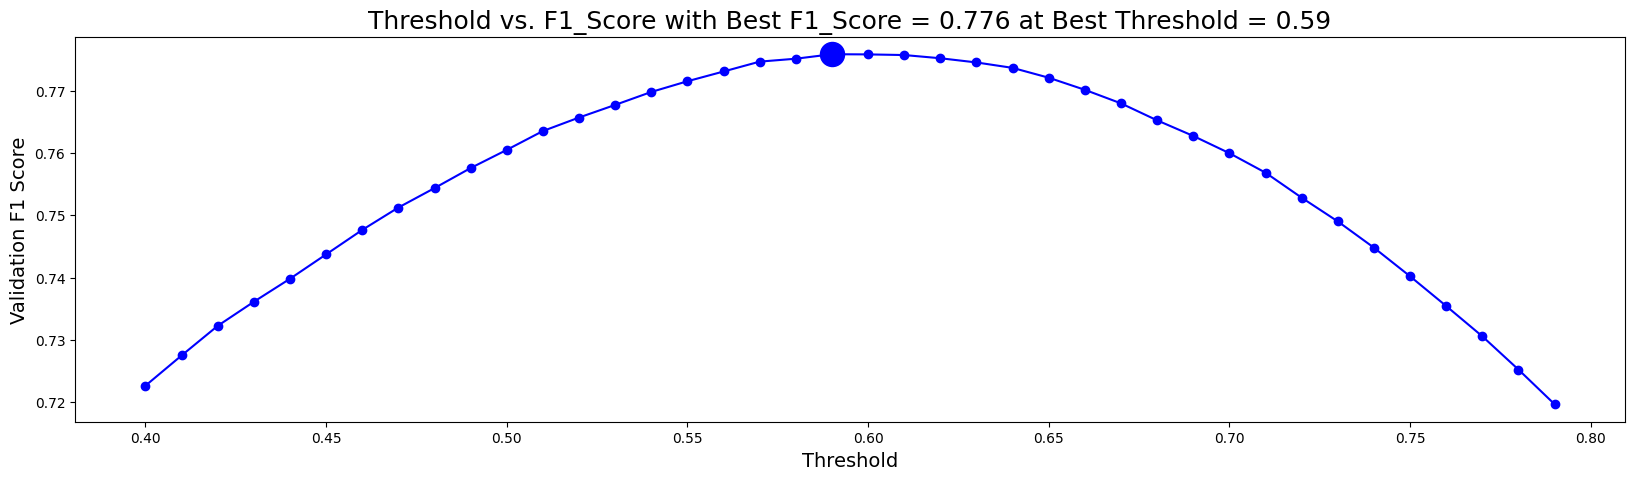

In [24]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,5))
plt.plot(thresholds,scores,'-o',color='blue')
plt.scatter(best_threshold, best_score, color='blue', s=300, alpha=1)
plt.xlabel('Threshold',size=14)
plt.ylabel('Validation F1 Score',size=14)
plt.title(f'Threshold vs. F1_Score with Best F1_Score = {best_score:.3f} at Best Threshold = {best_threshold:.3}',size=18)
plt.show()

In [25]:
for i in range(1,19):
    pred = (pred_df[i].values.reshape(-1) > best_threshold).astype("int")
    s = f1_score(true[i].values.reshape(-1), pred,average='macro')
    print(f"Q{i} F1_score: {s}")

pred = (pred_df.values.reshape(-1) > best_threshold).astype("int")
s = f1_score(true.values.reshape(-1), pred,average='macro')
print(f"OVERALL F1_score: {s}")

Q1 F1_score: 0.7425260976072412
Q2 F1_score: 0.7932440942616996
Q3 F1_score: 0.7682536508366089
Q4 F1_score: 0.6578810621302613
Q5 F1_score: 0.7159073102027901
Q6 F1_score: 0.7237947471334062
Q7 F1_score: 0.7047805164583215
Q8 F1_score: 0.6914768270822063
Q9 F1_score: 0.6942216725344621
Q10 F1_score: 0.6651733333477337
Q11 F1_score: 0.7120537774711306
Q12 F1_score: 0.6611456377457884
Q13 F1_score: 0.6574096480218365
Q14 F1_score: 0.754872313611588
Q15 F1_score: 0.7420768181863423
Q16 F1_score: 0.7628482412707329
Q17 F1_score: 0.7578730284213755
Q18 F1_score: 0.7580838977707838
OVERALL F1_score: 0.7758658020303503
